# Validation NW-UCLA

In [1]:
import os
from pathlib import Path
import sys
from dataclasses import dataclass
import torch
sys.path.append(str(Path(os.getcwd()).parent))

from settings.global_settings import GlobalSettings

config = GlobalSettings.get_config(
    config_file = "../config.ini",
    secrets_file = "../secrets.ini"
)
from dataset.video_loader import VideoDataLoader
from dataset.video_dataset import VideoDataset
from model.multimodal_har_model import MultiModalHARModel
from validation.result_types import ValidationResults, ValidationBranchTuple, DatasetValidation
from validation.quantitative_metrics import evaluate_model
from validation.extract_embeddings import extract_embeddings
from consts.charts_constants import CHARTS_LABELS

2025-12-12 13:22:55,778 - INFO - Sentry DSN set to: https://f4f21cc936b3ba9f5dbc1464b7a40ea4@o4504168838070272.ingest.us.sentry.io/4506464560414720
2025-12-12 13:22:55,779 - INFO - Sentry initialized with environment: development


Loading config...
Loading secrets...


### Defining Support Methods

In [2]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def visualize_tsne(
    reduced_tsne: np.ndarray,
    labels: np.ndarray,
    num_classes: int,
    n_components: int = 2,
    title: str = "t-SNE Visualization"
):
    """
    Plots t-SNE visualization of embeddings in 2D or 3D.
    """

    if n_components == 2:
        # ---- 2D Visualization ----
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(
            reduced_tsne[:, 0],
            reduced_tsne[:, 1],
            c=labels,
            cmap="tab10",
            s=40,
            alpha=0.8
        )
        plt.colorbar(scatter, ticks=range(num_classes))
        plt.title(title)
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.show()

    elif n_components == 3:
        # ---- 3D Visualization ----
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(
            reduced_tsne[:, 0],
            reduced_tsne[:, 1],
            reduced_tsne[:, 2],
            c=labels,
            cmap="tab10",
            s=40,
            alpha=0.85
        )

        fig.colorbar(scatter, ticks=range(num_classes))
        ax.set_title(title)
        ax.set_xlabel("t-SNE 1")
        ax.set_ylabel("t-SNE 2")
        ax.set_zlabel("t-SNE 3")
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("n_components must be 2 or 3")


**Parameters**

In [3]:
#MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_2025-11-11 09:45:21.993320.pht"
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_2025-11-14.423179.pht"
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251114_091037.pht"
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251116_145504.pht" # 80%
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251116_170800.pht" # 74%
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251116_181040.pht" # 73%
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251116_194147.pht" # 75% (2 head attention)
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251116_213645.pht" # 70% (1 head attention)
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251116_233217.pht" # 78% (3 head attention)
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251119_001517.pht" # 79% (attention pooling)
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251119_093012.pht" # 80% (attention pooling + enable layer norm)
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251119_103152.pht" # 79% (attention pooling + enable layer norm + redimension hidden layers + 4 heads of attention)
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251122_174517.pht" # 76% (exactly as suggested)
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251122_191441.pht" # 65% (with temporal encoder) 
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251122_215046.pht" # 71% (similar to above, but with more training - 80 epochs) 
# BEST 100% MODEL SO FAR
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251123_170515.pht" # 82.2% (similar to above, but with more training - 90 epochs and less dropout: 0.1) 
# MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251123_193350.pht" # 81.6% (similar to above, but with more training - 77 epochs and less dropout: 0.1 and CROSS ENTROPY LABEL SMOOTHING 0.1)

MODELS_PHT = {
    100: {
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251124_153224.pht",
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251124_174921.pht"
    },
    80: {
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_80_with_obj_20251126_174041.pht",
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_80_no_obj_20251126_192203.pht"
    },
    60: {
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_60_with_obj_20251126_222734.pht",
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_60_no_obj_20251126_232939.pht"
    },
    40: {
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_40_with_obj_20251127_105130.pht",
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_40_no_obj_20251127_114504.pht"
    },
    20: {
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_20_with_obj_20251127_124546.pht",
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_20_no_obj_20251127_132814.pht"
    },
}
MODEL_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251124_153224.pht" # 80.26% (confirming the baseline) 

# WITHOUT OBJECT BRANCH
MODEL_WITHOUT_OBJECT_PHT_PATH = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251124_174921.pht" # 75% 


# 80% EAR RATIO
## With Object Branch (65.13% acc)
MODEL_PHT_PATH_80 = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_80_with_obj_20251126_174041.pht"

## Without Object Branch (63.82% acc)
MODEL_PHT_PATH_80_NO_OBJ = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_80_no_obj_20251126_192203.pht"

# 60% EAR RATIO
## With Object Branch (65.13% acc)
MODEL_PHT_PATH_60 = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_60_with_obj_20251126_222734.pht"

## Without Object Branch (57.24% acc)
MODEL_PHT_PATH_60_NO_OBJ = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_60_no_obj_20251126_232939.pht"

# 40% EAR RATIO
## With Object Branch (46.71% acc)
MODEL_PHT_PATH_40 = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_40_with_obj_20251127_105130.pht"

## Without Object Branch (43.42% acc)
MODEL_PHT_PATH_40_NO_OBJ = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_40_no_obj_20251127_114504.pht"

# 20% EAR RATIO
## With Object Branch (42.76% acc)
MODEL_PHT_PATH_20 = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_20_with_obj_20251127_124546.pht"

## Without Object Branch (30.26% acc)
MODEL_PHT_PATH_20_NO_OBJ = "/Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_20_no_obj_20251127_132814.pht"



VALIDATION_DIR = os.path.join(
    config.model_settings.video_data_dir,
    "validation"
)

In [4]:
OBSERVATION_RATE = [100, 80, 60, 40, 20]

## Loading Dataset

In [5]:
validation_video_data_loader = VideoDataLoader(
    path=VALIDATION_DIR,
)
validation_dataset = VideoDataset(
    video_data_loader=validation_video_data_loader,
    normalization_type="across_frames",
)

len(validation_dataset)
for _ in validation_dataset:
    pass


display(len(validation_dataset.labels_map))

2025-12-12 13:22:58,500 - INFO - [VideoDataLoader] Loding action videos for action: a01
2025-12-12 13:22:58,541 - INFO - [VideoDataLoader] Loding action videos for action: a02
2025-12-12 13:22:58,586 - INFO - [VideoDataLoader] Loding action videos for action: a03
2025-12-12 13:22:58,612 - INFO - [VideoDataLoader] Loding action videos for action: a04
2025-12-12 13:22:58,643 - INFO - [VideoDataLoader] Loding action videos for action: a05
2025-12-12 13:22:58,667 - INFO - [VideoDataLoader] Loding action videos for action: a06
2025-12-12 13:22:58,692 - INFO - [VideoDataLoader] Loding action videos for action: a08
2025-12-12 13:22:58,844 - INFO - [VideoDataLoader] Loding action videos for action: a09
2025-12-12 13:22:58,893 - INFO - [VideoDataLoader] Loding action videos for action: a11
2025-12-12 13:22:58,923 - INFO - [VideoDataLoader] Loding action videos for action: a12


10

In [6]:
dataset_validation = DatasetValidation(name="NW-UCLA")

## Loading Model

In [7]:
har_model, _ = MultiModalHARModel.load(
    checkpoint_path=MODEL_PHT_PATH
)

har_model_without_object_branch, _ = MultiModalHARModel.load(
    checkpoint_path=MODEL_WITHOUT_OBJECT_PHT_PATH
)

2025-12-12 13:22:59,354 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251124_153224.pht...
2025-12-12 13:22:59,599 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-12 13:22:59,600 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-12 13:22:59,659 - INFO - ✅ Model loaded and ready for inference
2025-12-12 13:22:59,660 - INFO - Loading model from /Volumes/KODAK/masters/model/validatio

## Running Validation

- Accuracy
- AUC
- Getting Embeddings

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
har_model.to(device)

for obs_rate in OBSERVATION_RATE:
    ear_ratio = obs_rate / 100.0
    print(f"Evaluating for observation rate: {obs_rate}% (EAR ratio: {ear_ratio})")
    validation_dataset_obs = VideoDataset(
        video_data_loader=validation_video_data_loader,
        normalization_type="across_frames",
        EAR_ratio=ear_ratio,
    )
    har_model, _ = MultiModalHARModel.load(
        checkpoint_path=MODELS_PHT[obs_rate]["with_obj"]
    )

    har_model_without_object_branch, _ = MultiModalHARModel.load(
        checkpoint_path=MODELS_PHT[obs_rate]["without_obj"]
    )
    
    dataset_validation[obs_rate] = ValidationBranchTuple(
        with_object_branch=ValidationResults(
            quantitative_metrics=evaluate_model(har_model, validation_dataset_obs, device),
            embeddings=extract_embeddings(har_model, validation_dataset_obs, device)
        ),
        without_object_branch=ValidationResults(
            quantitative_metrics=evaluate_model(har_model_without_object_branch, validation_dataset_obs, device),
            embeddings=extract_embeddings(har_model_without_object_branch, validation_dataset_obs, device)
        )
    )


2025-12-12 13:22:59,875 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.0_nw_ucla_20251124_153224.pht...
2025-12-12 13:22:59,883 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-12 13:22:59,884 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-12 13:22:59,898 - INFO - ✅ Model loaded and ready for inference
2025-12-12 13:22:59,899 - INFO - Loading model from /Volumes/KODAK/masters/model/validatio

Evaluating for observation rate: 100% (EAR ratio: 1.0)


Extracting embeddings: 100%|██████████| 152/152 [00:02<00:00, 73.91it/s]


Evaluating for observation rate: 80% (EAR ratio: 0.8)


2025-12-12 13:23:10,580 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_80_with_obj_20251126_174041.pht...
2025-12-12 13:23:10,827 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-12 13:23:10,828 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-12 13:23:10,843 - INFO - ✅ Model loaded and ready for inference
2025-12-12 13:23:10,844 - INFO - Loading model from /Volumes/KODAK/masters/mod

Evaluating for observation rate: 60% (EAR ratio: 0.6)


2025-12-12 13:23:19,544 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-12 13:23:19,547 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-12 13:23:19,561 - INFO - ✅ Model loaded and ready for inference
2025-12-12 13:23:19,562 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_60_no_obj_20251126_232939.pht...
2025-12-12 13:23:19,750 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat

Evaluating for observation rate: 40% (EAR ratio: 0.4)


2025-12-12 13:23:26,223 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-12 13:23:26,223 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-12 13:23:26,237 - INFO - ✅ Model loaded and ready for inference
2025-12-12 13:23:26,238 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_40_no_obj_20251127_114504.pht...
2025-12-12 13:23:26,425 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat

Evaluating for observation rate: 20% (EAR ratio: 0.2)


2025-12-12 13:23:31,198 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-12 13:23:31,198 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 10, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-12 13:23:31,212 - INFO - ✅ Model loaded and ready for inference
2025-12-12 13:23:31,214 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NW-UCLA/model/har_model_v1.0.1_nw_ucla_20_no_obj_20251127_132814.pht...
2025-12-12 13:23:31,404 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat

### Quantitative Comparison
- Plotting Accuracy and AUC values over observation progression - Table
- Plotting Accuracy and AUC values over observation progression - Line Chart

In [9]:
for obs_rate in OBSERVATION_RATE:
    print(f"Observation Rate: {obs_rate}%")
    print("With Object Branch:")
    print(str(dataset_validation[obs_rate].with_object_branch.quantitative_metrics))
    print("Without Object Branch:")
    print(str(dataset_validation[obs_rate].without_object_branch.quantitative_metrics))
    print("--------------------------------------------------")

Observation Rate: 100%
With Object Branch:
Accuracy: 0.8026, Macro AUC: 0.9629, Micro AUC: 0.9628
Without Object Branch:
Accuracy: 0.7566, Macro AUC: 0.9197, Micro AUC: 0.9191
--------------------------------------------------
Observation Rate: 80%
With Object Branch:
Accuracy: 0.6513, Macro AUC: 0.8626, Micro AUC: 0.8639
Without Object Branch:
Accuracy: 0.6382, Macro AUC: 0.9055, Micro AUC: 0.9106
--------------------------------------------------
Observation Rate: 60%
With Object Branch:
Accuracy: 0.6579, Macro AUC: 0.8808, Micro AUC: 0.8804
Without Object Branch:
Accuracy: 0.5724, Macro AUC: 0.8539, Micro AUC: 0.8499
--------------------------------------------------
Observation Rate: 40%
With Object Branch:
Accuracy: 0.4671, Macro AUC: 0.7943, Micro AUC: 0.7951
Without Object Branch:
Accuracy: 0.4342, Macro AUC: 0.7853, Micro AUC: 0.7860
--------------------------------------------------
Observation Rate: 20%
With Object Branch:
Accuracy: 0.4276, Macro AUC: 0.7965, Micro AUC: 0.801

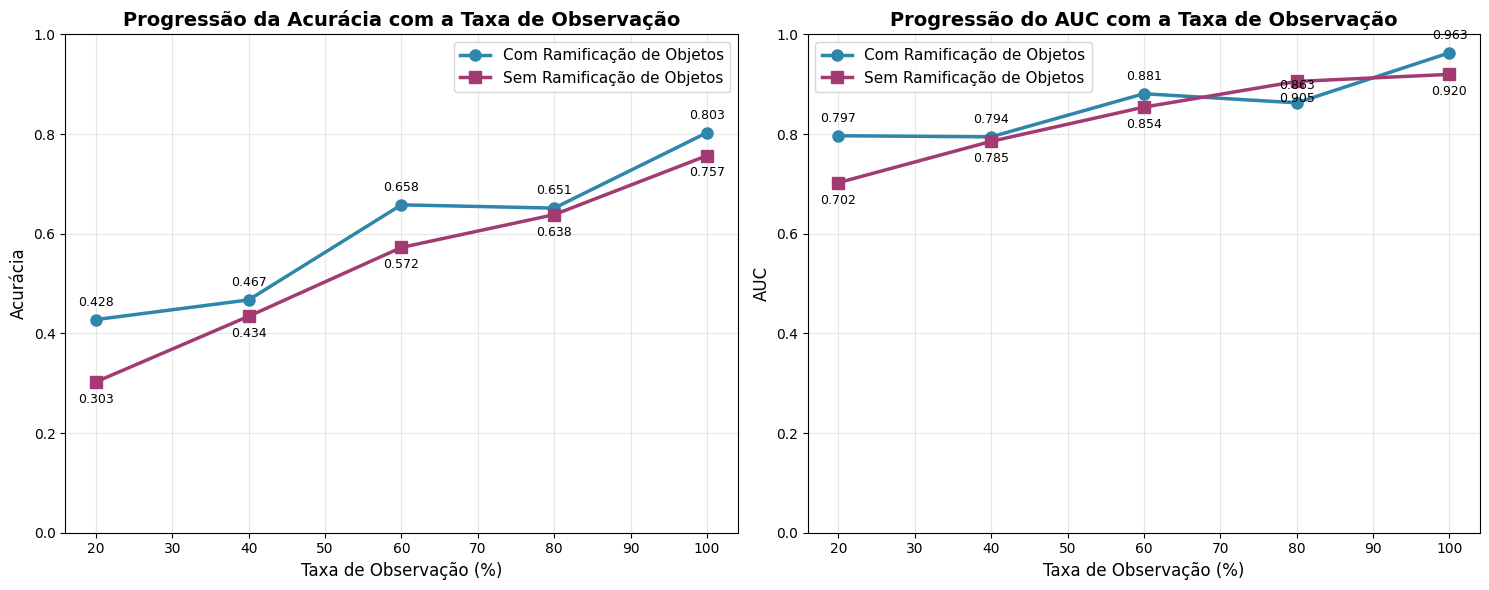


QUANTITATIVE METRICS SUMMARY TABLE
Obs Rate   With Obj Acc Without Obj Acc With Obj AUC Without Obj AUC
--------------------------------------------------------------------------------
100%        0.803        0.757           0.963        0.920          
80%        0.651        0.638           0.863        0.905          
60%        0.658        0.572           0.881        0.854          
40%        0.467        0.434           0.794        0.785          
20%        0.428        0.303           0.797        0.702          

PERFORMANCE DIFFERENCE ANALYSIS
Obs Rate   Acc Difference  AUC Difference 
------------------------------------------------------------
100%        0.046           0.043          
80%        0.013           -0.043         
60%        0.086           0.027          
40%        0.033           0.009          
20%        0.125           0.094          


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_quantitative_metrics_progression(dataset_validation, observation_rates):
    """
    Plot accuracy and macro AUC progression over observation rates.
    
    Args:
        dataset_validation: DatasetValidation object containing results
        observation_rates: List of observation rates (e.g., [100, 80, 60, 40, 20])
    """
    # Extract metrics
    with_obj_accuracy = []
    without_obj_accuracy = []
    with_obj_macro_auc = []
    without_obj_macro_auc = []
    
    for obs_rate in observation_rates:
        # Get validation results for this observation rate
        validation_results = dataset_validation[obs_rate]
        
        # Extract metrics for with object branch
        with_obj_metrics = validation_results.with_object_branch.quantitative_metrics
        with_obj_accuracy.append(with_obj_metrics.accuracy)
        with_obj_macro_auc.append(with_obj_metrics.macro_auc)
        
        # Extract metrics for without object branch
        without_obj_metrics = validation_results.without_object_branch.quantitative_metrics
        without_obj_accuracy.append(without_obj_metrics.accuracy)
        without_obj_macro_auc.append(without_obj_metrics.macro_auc)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Accuracy Progression
    ax1.plot(observation_rates, with_obj_accuracy, 
             marker='o', linewidth=2.5, markersize=8, 
             color='#2E86AB', label=CHARTS_LABELS.with_object_branch)
    ax1.plot(observation_rates, without_obj_accuracy, 
             marker='s', linewidth=2.5, markersize=8, 
             color='#A23B72', label=CHARTS_LABELS.without_object_branch)
    
    ax1.set_xlabel(CHARTS_LABELS.quantitative_observation_rate, fontsize=12)
    ax1.set_ylabel(CHARTS_LABELS.quantitative_accuracy, fontsize=12)
    ax1.set_title(CHARTS_LABELS.quantitative_accuracy_progression_over_observation_rate, fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)  # Accuracy is typically 0-1
    
    # Add value annotations
    for i, (obs_rate, with_acc, without_acc) in enumerate(zip(observation_rates, with_obj_accuracy, without_obj_accuracy)):
        ax1.annotate(f'{with_acc:.3f}', 
                    (obs_rate, with_acc), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', fontsize=9)
        ax1.annotate(f'{without_acc:.3f}', 
                    (obs_rate, without_acc), 
                    textcoords="offset points", 
                    xytext=(0,-15), 
                    ha='center', fontsize=9)
    
    # Plot 2: Macro AUC Progression
    ax2.plot(observation_rates, with_obj_macro_auc, 
             marker='o', linewidth=2.5, markersize=8, 
             color='#2E86AB', label=CHARTS_LABELS.with_object_branch)
    ax2.plot(observation_rates, without_obj_macro_auc, 
             marker='s', linewidth=2.5, markersize=8, 
             color='#A23B72', label=CHARTS_LABELS.without_object_branch)
    
    ax2.set_xlabel(CHARTS_LABELS.quantitative_observation_rate, fontsize=12)
    ax2.set_ylabel(CHARTS_LABELS.quantitative_auc, fontsize=12)
    ax2.set_title(CHARTS_LABELS.quantitative_auc_progression_over_observation_rate, fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)  # AUC is typically 0-1
    
    # Add value annotations
    for i, (obs_rate, with_auc, without_auc) in enumerate(zip(observation_rates, with_obj_macro_auc, without_obj_macro_auc)):
        ax2.annotate(f'{with_auc:.3f}', 
                    (obs_rate, with_auc), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', fontsize=9)
        ax2.annotate(f'{without_auc:.3f}', 
                    (obs_rate, without_auc), 
                    textcoords="offset points", 
                    xytext=(0,-15), 
                    ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*80)
    print("QUANTITATIVE METRICS SUMMARY TABLE")
    print("="*80)
    print(f"{'Obs Rate':<10} {'With Obj Acc':<12} {'Without Obj Acc':<15} {'With Obj AUC':<12} {'Without Obj AUC':<15}")
    print("-"*80)
    
    for i, obs_rate in enumerate(observation_rates):
        print(f"{obs_rate}%{'':<7} {with_obj_accuracy[i]:<12.3f} {without_obj_accuracy[i]:<15.3f} "
              f"{with_obj_macro_auc[i]:<12.3f} {without_obj_macro_auc[i]:<15.3f}")
    
    # Calculate performance differences
    print("\n" + "="*60)
    print("PERFORMANCE DIFFERENCE ANALYSIS")
    print("="*60)
    print(f"{'Obs Rate':<10} {'Acc Difference':<15} {'AUC Difference':<15}")
    print("-"*60)
    
    for i, obs_rate in enumerate(observation_rates):
        acc_diff = with_obj_accuracy[i] - without_obj_accuracy[i]
        auc_diff = with_obj_macro_auc[i] - without_obj_macro_auc[i]
        print(f"{obs_rate}%{'':<7} {acc_diff:<15.3f} {auc_diff:<15.3f}")

# Usage in your notebook
plot_quantitative_metrics_progression(dataset_validation, OBSERVATION_RATE)

### Qualitative Comparison

- Graphic Analysis - Plotting with t-SNE
- Progression over observation rate

#### EAR (Early Action Recognition) Validation

t-SNE Visualization for Observation Rate: 100%


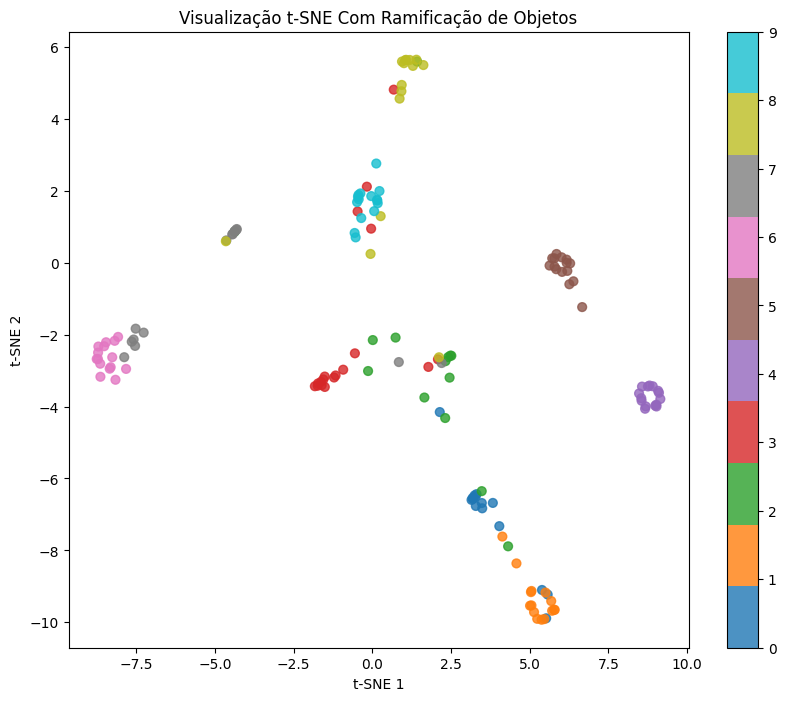

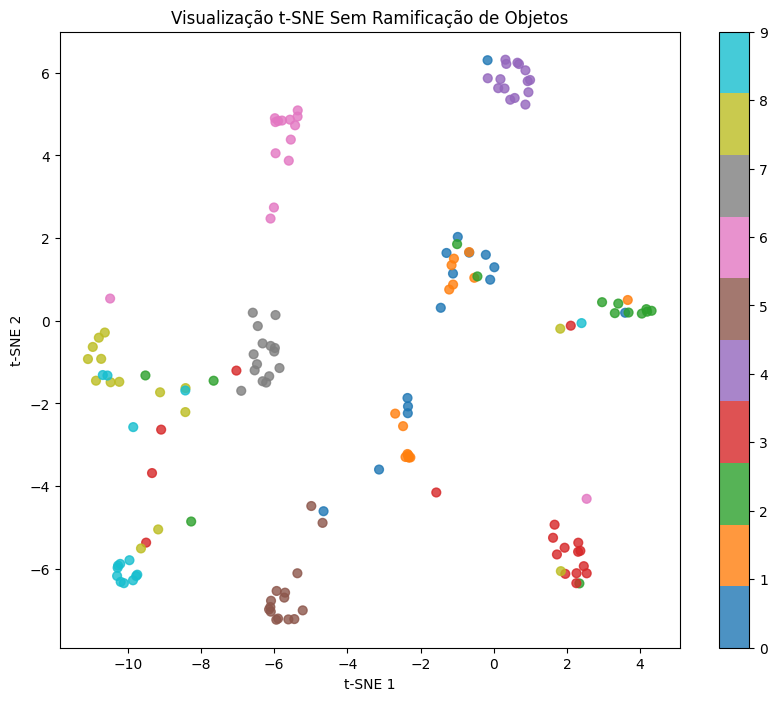

--------------------------------------------------
t-SNE Visualization for Observation Rate: 80%


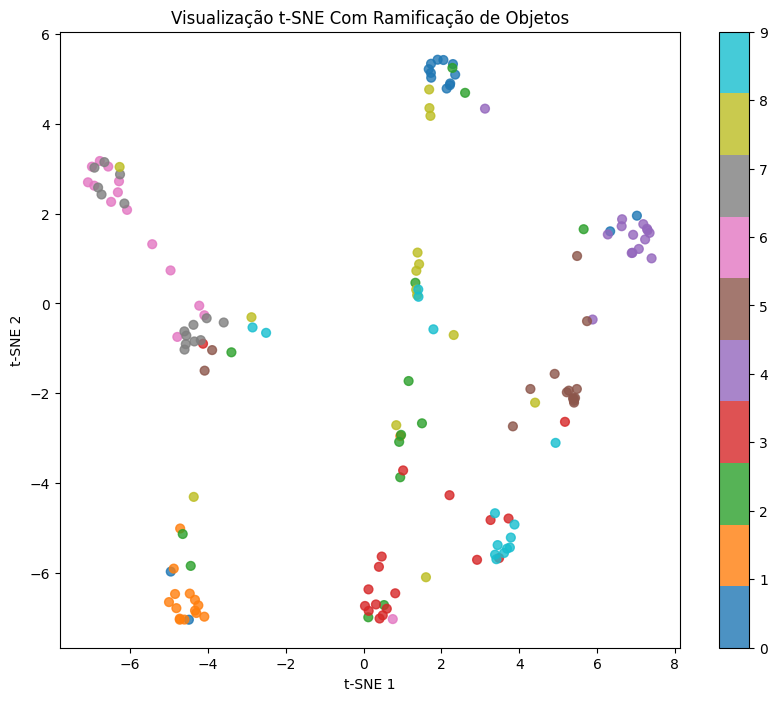

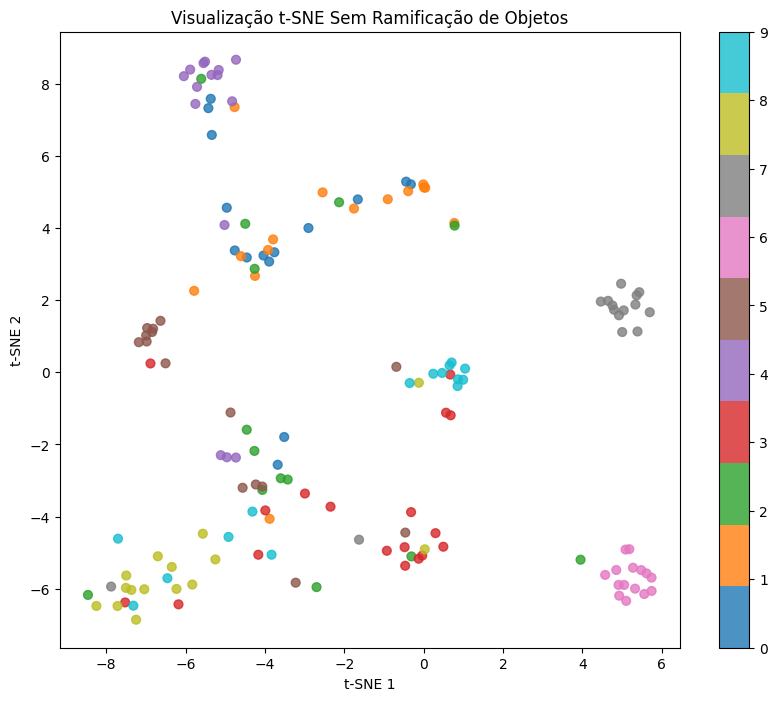

--------------------------------------------------
t-SNE Visualization for Observation Rate: 60%


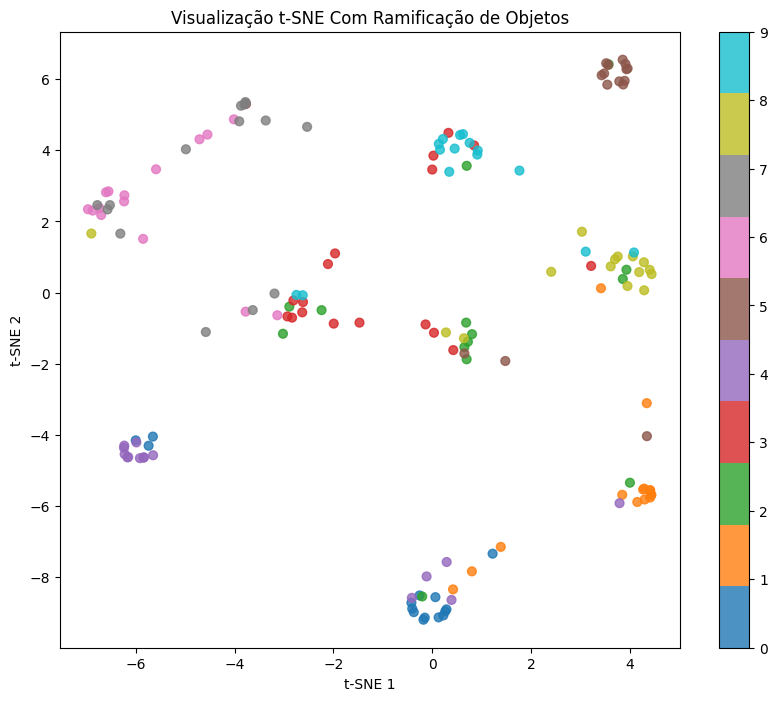

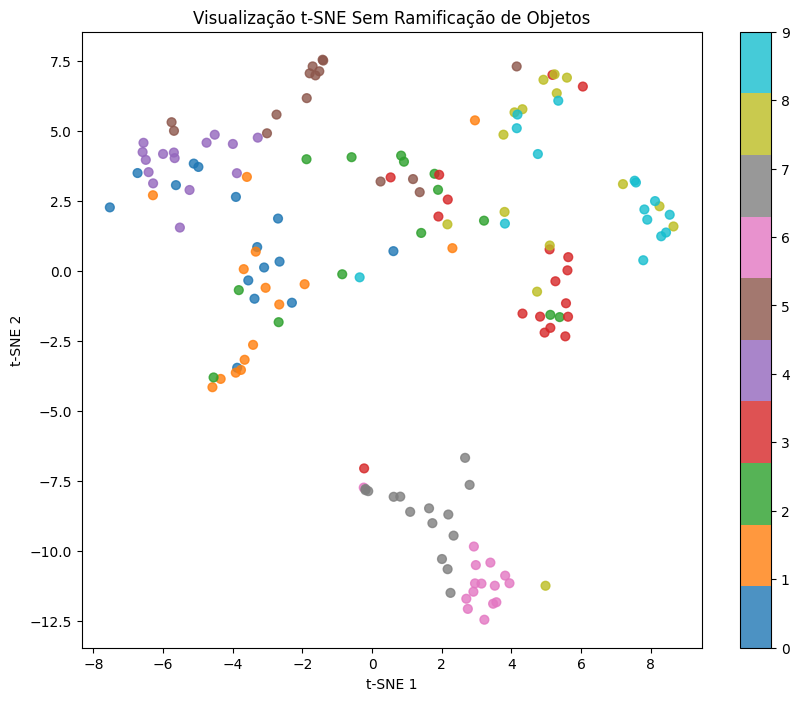

--------------------------------------------------
t-SNE Visualization for Observation Rate: 40%


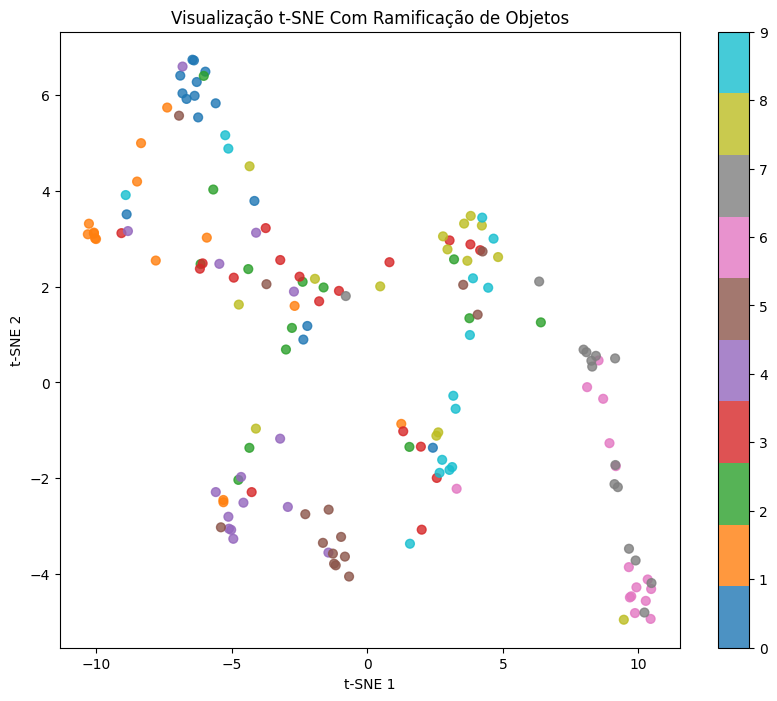

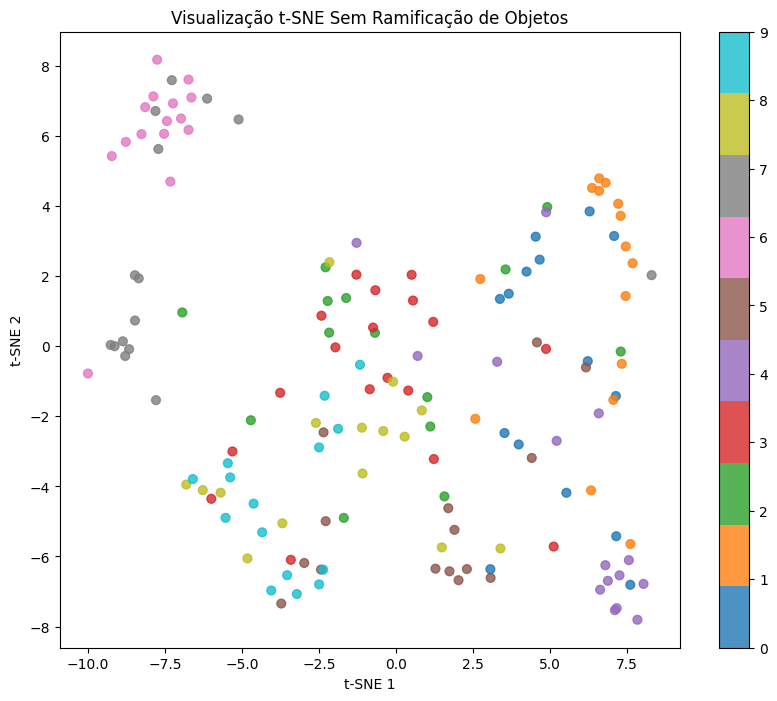

--------------------------------------------------
t-SNE Visualization for Observation Rate: 20%


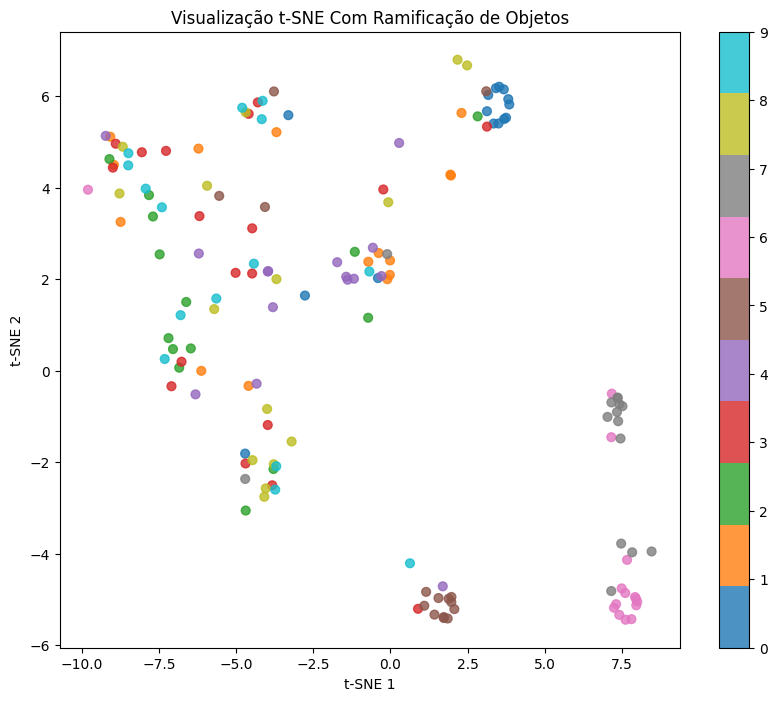

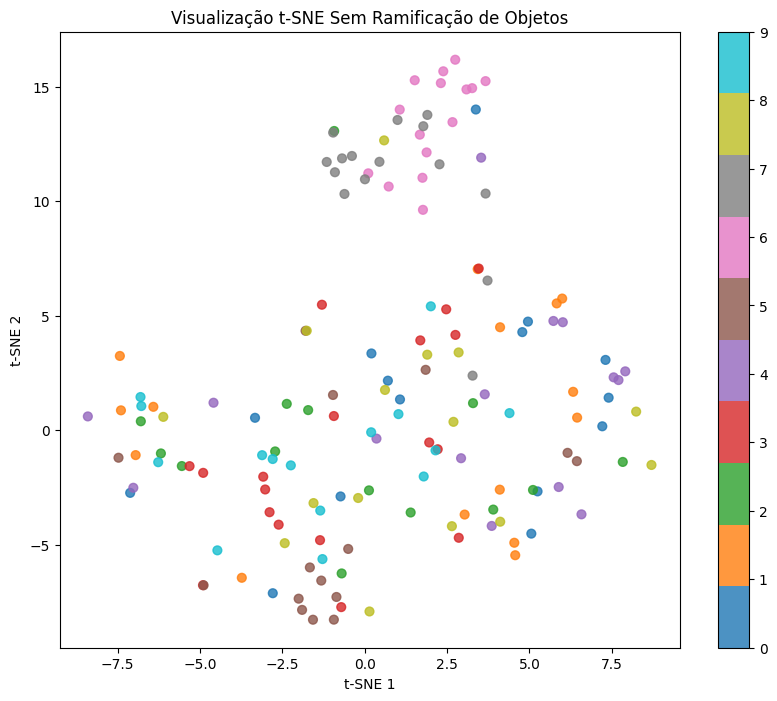

--------------------------------------------------


In [11]:

from sklearn.manifold import TSNE
perplexity = 30
random_state = 42
t_sne_components = 2

for obs_rate in OBSERVATION_RATE:
    embeddings, labels = dataset_validation[obs_rate].with_object_branch.embeddings
    embeddings_without_object, labels_without_object = dataset_validation[obs_rate].without_object_branch.embeddings


    tsne = TSNE(
        n_components=t_sne_components,
        perplexity=perplexity,
        random_state=random_state,
        init="pca"
    )
    reduced = tsne.fit_transform(embeddings)

    tsne_without_object = TSNE(
        n_components=t_sne_components,
        perplexity=perplexity,
        random_state=random_state,
        init="pca"
    )
    reduced_without_object = tsne_without_object.fit_transform(embeddings_without_object)
    
    print(f"t-SNE Visualization for Observation Rate: {obs_rate}%")
    visualize_tsne(
        reduced,
        labels,
        num_classes=10,
        n_components=t_sne_components,
        title=CHARTS_LABELS.t_sne_visualization + " " + CHARTS_LABELS.with_object_branch
    )
    visualize_tsne(
        reduced_without_object,
        labels_without_object,
        num_classes=10,
        n_components=t_sne_components,
        title=CHARTS_LABELS.t_sne_visualization + " " + CHARTS_LABELS.without_object_branch
    )
    print("--------------------------------------------------")